# **Library AND Load data**

In [ ]:
from google.colab import drive
drive.mount('/content/Drive/')

Mounted at /content/Drive/


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [ ]:
# Chọn tệp JSON API Token từ máy tính của bạn
uploaded = files.upload()

# Di chuyển tệp JSON vào thư mục ~/.kaggle/
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Tải xuống bộ dữ liệu từ Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Giải nén bộ dữ liệu
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# **Processing data**

In [ ]:
# Danh sách các labels
labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

# Đường dẫn đến thư mục chứa dữ liệu
path = "/content/COVID-19_Radiography_Dataset"

# Kết hợp đường dẫn
data_dir = os.path.join(path)

# Khởi tạo danh sách data
data = []

# Duyệt qua từng label
for id, label in enumerate(labels):
    # Duyệt qua từng tệp tin trong thư mục của label hiện tại
    for file in os.listdir(os.path.join(data_dir, label + '/images')):
        # Thêm thông tin tệp tin và label vào danh sách data
        data.append(['{}/images/{}'.format(label, file), label])

# Giữ lại 2 cột: 'image_file' và 'result'
data = pd.DataFrame(data, columns=['image_file', 'result'])

# Tạo cột 'path' trong DataFrame data, kết hợp đường dẫn đầy đủ
data['path'] = path + '/' + data['image_file']

In [ ]:
# Khởi tạo danh sách pixel_img để lưu trữ các ảnh
pixel_img = []

# Duyệt qua từng đường dẫn ảnh trong data
for image in tqdm(data['path']):
    # Mở ảnh và chuyển đổi sang ảnh đen trắng (grayscale)
    img = Image.open(image)
    img = ImageOps.grayscale(img)

    # Thay đổi kích thước ảnh thành 64x64 pixel
    img = img.resize((64, 64))

    # Chuyển đổi ảnh thành mảng numpy
    img = np.asarray(img)

    # Thay đổi hình dạng của ảnh để có kích thước (64, 64, 1)
    img = img.reshape((64, 64, 1))

    # Thêm ảnh vào danh sách pixel_img
    pixel_img.append(img)

# Chuyển đổi danh sách pixel_img thành mảng numpy
pixel_img = np.array(pixel_img)

# Tạo nhãn cho ảnh dựa trên label từ data
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3})

100%|██████████| 21165/21165 [00:47<00:00, 449.48it/s]


In [ ]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_all, X_test_all, y_train, y_test = train_test_split(pixel_img, label_img, test_size=0.2, stratify=label_img)

# Số lượng lớp
num_classes = len(np.unique(y_train))

# Chuyển đổi nhãn thành one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Chuẩn hóa giá trị của dữ liệu hình ảnh về khoảng [0, 1]
X_train = X_train_all.astype('float32') / 255
X_test = X_test_all.astype('float32') / 255

# Kích thước đầu vào
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
def evaluate_model(model, X_test, y_test):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Tính toán các thông số đánh giá
    accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
    report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nPrecision, Recall, F1-score:\n")
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average=None)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average=None)
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average=None)
    for i in range(len(labels)):
        print(labels[i])
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1-score:", f1[i])
        print()

    # Tạo ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# **3.6. ConvNet (CNN2)**

## ConvNet (CNN2)

In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [ ]:
# Khởi tạo mô hình CNN
cnn2_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        # Layer Convolution 1
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        # Layer Convolution 2
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),

        # Layer Max Pooling 1
        layers.MaxPooling2D(pool_size=(2,2)),

        # Layer Dropout 1
        layers.Dropout(0.2, seed=235),

        # Layer Convolution 3
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        # Layer Convolution 4
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),

        # Layer Max Pooling 2
        layers.MaxPooling2D(pool_size=(2,2)),

        # Layer Dropout 2
        layers.Dropout(0.2, seed=235),

        # Layer Convolution 5
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        # Layer Convolution 6
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),

        # Layer Max Pooling 3
        layers.MaxPooling2D(pool_size=(2,2)),

        # Layer Dropout 3
        layers.Dropout(0.2, seed=235),

        # Layer Convolution 7
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        # Layer Convolution 8
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),

        # Layer Max Pooling 4
        layers.MaxPooling2D(pool_size=(2,2)),

        # Layer Dropout 4
        layers.Dropout(0.2, seed=235),

        # Layer Flatten
        layers.Flatten(),

        # Layer Dropout 5
        layers.Dropout(0.5, seed=235),

        # Layer Dense 1
        layers.Dense(512, activation="relu"),

        # Layer Dense 2
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# In thông tin của mô hình
cnn2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                        

In [ ]:
cnn2_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn2_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
133/133 [==============================] - 18s 43ms/step - loss: 1.1130 - accuracy: 0.5199 - val_loss: 0.8805 - val_accuracy: 0.6376
Epoch 2/50
133/133 [==============================] - 6s 43ms/step - loss: 0.8920 - accuracy: 0.6453 - val_loss: 0.7955 - val_accuracy: 0.6860
Epoch 3/50
133/133 [==============================] - 5s 38ms/step - loss: 0.7941 - accuracy: 0.6836 - val_loss: 0.7691 - val_accuracy: 0.6872
Epoch 4/50
133/133 [==============================] - 4s 33ms/step - loss: 0.7327 - accuracy: 0.7030 - val_loss: 0.7327 - val_accuracy: 0.7300
Epoch 5/50
133/133 [==============================] - 5s 35ms/step - loss: 0.6891 - accuracy: 0.7261 - val_loss: 0.7252 - val_accuracy: 0.7300
Epoch 6/50
133/133 [==============================] - 4s 33ms/step - loss: 0.6573 - accuracy: 0.7406 - val_loss: 0.5892 - val_accuracy: 0.7831
Epoch 7/50
133/133 [==============================] - 4s 34ms/step - loss: 0.6328 - accuracy: 0.7492 - val_loss: 0.6724 - val_accuracy: 0.714

133/133 [==============================] - 1s 2ms/step
Accuracy: 0.9114103472714387

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.90      0.96      0.93      2038
          COVID       0.96      0.87      0.92       723
   Lung_Opacity       0.91      0.84      0.87      1203
Viral Pneumonia       0.91      0.97      0.94       269

       accuracy                           0.91      4233
      macro avg       0.92      0.91      0.91      4233
   weighted avg       0.91      0.91      0.91      4233


Precision, Recall, F1-score:

Normal
Precision: 0.8999538958045182
Recall: 0.957801766437684
F1-score: 0.9279771808889946

COVID
Precision: 0.961890243902439
Recall: 0.8727524204702628
F1-score: 0.9151559100797679

Lung_Opacity
Precision: 0.9054415700267618
Recall: 0.8437240232751455
F1-score: 0.8734939759036146

Viral Pneumonia
Precision: 0.9059233449477352
Recall: 0.966542750929368
F1-score: 0.935251798561151



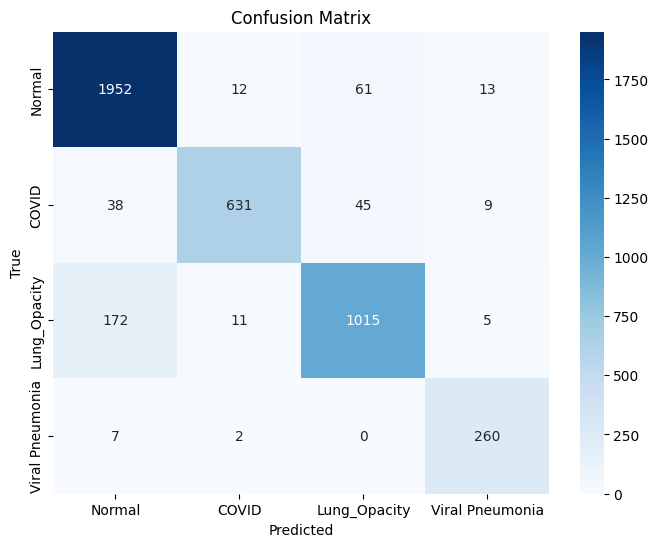

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_model, X_test, y_test)

In [ ]:
# save
cnn2_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_normal.h5")

## ConvNet (CNN2) - Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
cnn2_model_Oversampling = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_model_Oversampling.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
num_samples = np.bincount(np.argmax(y_train, axis=1))
max_samples = max(num_samples)
oversampling_ratio = 2
sampling_strategy = {label: int(count * oversampling_ratio) for label, count in enumerate(num_samples)}
# Reshape dữ liệu hình ảnh thành ma trận 2 chiều
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Sử dụng RandomOverSampler với dữ liệu đã được làm phẳng
over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_oversampled_flattened, y_train_oversampled = over_sampler.fit_resample(X_train_flattened, y_train)

# Đưa dữ liệu trở lại kích thước ban đầu
X_train_oversampled = X_train_oversampled_flattened.reshape(X_train_oversampled_flattened.shape[0], input_shape[0], input_shape[1], input_shape[2])

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (16308) in class 0 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (9618) in class 2 will be larger than the number of samples in the majority class (class #0 -> 8154)
  warnings.warn(


In [ ]:
cnn2_model_Oversampling.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn2_model_Oversampling.fit(X_train_oversampled, y_train_oversampled, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
265/265 [==============================] - 13s 39ms/step - loss: 1.0323 - accuracy: 0.5635 - val_loss: 0.8456 - val_accuracy: 0.6785
Epoch 2/50
265/265 [==============================] - 9s 35ms/step - loss: 0.7685 - accuracy: 0.6917 - val_loss: 0.8397 - val_accuracy: 0.7021
Epoch 3/50
265/265 [==============================] - 9s 35ms/step - loss: 0.6730 - accuracy: 0.7306 - val_loss: 0.5954 - val_accuracy: 0.7791
Epoch 4/50
265/265 [==============================] - 9s 35ms/step - loss: 0.6148 - accuracy: 0.7585 - val_loss: 0.5429 - val_accuracy: 0.8027
Epoch 5/50
265/265 [==============================] - 9s 34ms/step - loss: 0.5683 - accuracy: 0.7760 - val_loss: 0.5497 - val_accuracy: 0.8060
Epoch 6/50
265/265 [==============================] - 9s 35ms/step - loss: 0.5288 - accuracy: 0.7941 - val_loss: 0.5597 - val_accuracy: 0.7914
Epoch 7/50
265/265 [==============================] - 9s 35ms/step - loss: 0.4961 - accuracy: 0.8098 - val_loss: 0.4457 - val_accuracy: 0.832

133/133 [==============================] - 0s 3ms/step
Accuracy: 0.9265296480037798

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.93      0.94      0.94      2038
          COVID       0.96      0.91      0.94       723
   Lung_Opacity       0.89      0.90      0.90      1203
Viral Pneumonia       0.95      0.95      0.95       269

       accuracy                           0.93      4233
      macro avg       0.93      0.93      0.93      4233
   weighted avg       0.93      0.93      0.93      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9321705426356589
Recall: 0.9440628066732091
F1-score: 0.9380789858605557

COVID
Precision: 0.9606986899563319
Recall: 0.9128630705394191
F1-score: 0.9361702127659575

Lung_Opacity
Precision: 0.8920922570016474
Recall: 0.9002493765586035
F1-score: 0.8961522548613984

Viral Pneumonia
Precision: 0.9514925373134329
Recall: 0.9479553903345725
F1-score: 0.9497206703910615



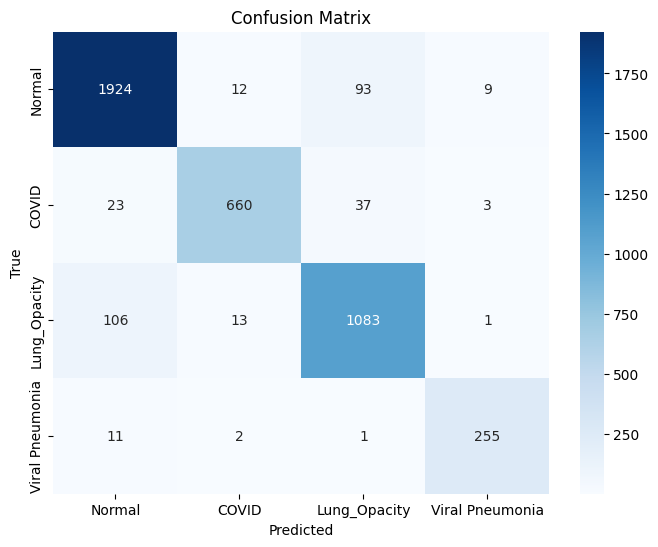

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_model_Oversampling, X_test, y_test)

In [ ]:
# save
cnn2_model_Oversampling.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_Oversampling.h5")

## ConvNet (CNN2) - Kết hợp Oversampling và Undersampling

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
cnn2_over_under_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_over_under_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Kích thước đầu vào
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Chuyển đổi X_train thành ma trận 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Áp dụng phương pháp Over-Under Sampling bằng SMOTEENN
sampler = SMOTEENN()
X_over_under_sampling, y_over_under_sampling = sampler.fit_resample(X_train_2d, y_train)
X_over_under_sampling = X_over_under_sampling.reshape(X_over_under_sampling.shape[0], 64, 64, 1)

In [ ]:
cnn2_over_under_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn2_over_under_model.fit(X_over_under_sampling, y_over_under_sampling, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
199/199 [==============================] - 10s 39ms/step - loss: 0.9458 - accuracy: 0.5848 - val_loss: 1.3894 - val_accuracy: 0.4746
Epoch 2/50
199/199 [==============================] - 7s 34ms/step - loss: 0.5957 - accuracy: 0.7616 - val_loss: 1.2105 - val_accuracy: 0.5391
Epoch 3/50
199/199 [==============================] - 7s 33ms/step - loss: 0.4827 - accuracy: 0.8113 - val_loss: 0.7913 - val_accuracy: 0.6603
Epoch 4/50
199/199 [==============================] - 7s 34ms/step - loss: 0.4103 - accuracy: 0.8398 - val_loss: 0.9090 - val_accuracy: 0.6494
Epoch 5/50
199/199 [==============================] - 7s 34ms/step - loss: 0.3591 - accuracy: 0.8642 - val_loss: 0.9987 - val_accuracy: 0.6482
Epoch 6/50
199/199 [==============================] - 7s 35ms/step - loss: 0.3229 - accuracy: 0.8776 - val_loss: 0.7561 - val_accuracy: 0.7196
Epoch 7/50
199/199 [==============================] - 7s 34ms/step - loss: 0.2893 - accuracy: 0.8905 - val_loss: 0.8070 - val_accuracy: 0.715

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.8554216867469879

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.94      0.80      0.86      2038
          COVID       0.83      0.92      0.87       723
   Lung_Opacity       0.76      0.89      0.82      1203
Viral Pneumonia       0.90      0.97      0.93       269

       accuracy                           0.86      4233
      macro avg       0.86      0.90      0.87      4233
   weighted avg       0.87      0.86      0.86      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9435718440954043
Recall: 0.7958783120706575
F1-score: 0.8634548842161298

COVID
Precision: 0.8257107540173053
Recall: 0.9239280774550485
F1-score: 0.8720626631853787

Lung_Opacity
Precision: 0.7565463552724699
Recall: 0.8886118038237739
F1-score: 0.8172782874617738

Viral Pneumonia
Precision: 0.8972602739726028
Recall: 0.9739776951672863
F1-score: 0.9340463458110517



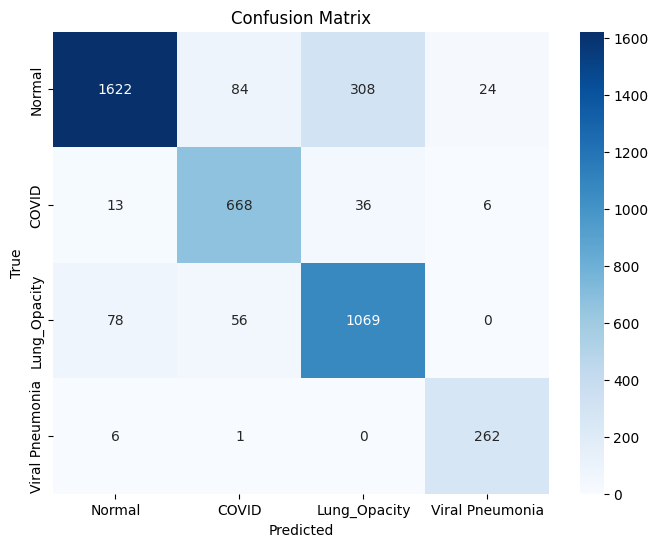

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_over_under_model, X_test, y_test)

In [ ]:
# save
cnn2_over_under_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_Over_Under.h5")

## ConvNet (CNN2) - Weighted Loss Function (sample weights)

In [ ]:
from sklearn.utils import compute_sample_weight

In [ ]:
cnn2_sample_weight_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_sample_weight_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_27 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Tính toán trọng số mẫu
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
cnn2_sample_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn2_sample_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), sample_weight=sample_weights)

Epoch 1/50
133/133 [==============================] - 9s 37ms/step - loss: 0.8288 - accuracy: 0.1883 - val_loss: 1.1435 - val_accuracy: 0.5261
Epoch 2/50
133/133 [==============================] - 5s 35ms/step - loss: 0.5938 - accuracy: 0.4570 - val_loss: 0.9668 - val_accuracy: 0.6109
Epoch 3/50
133/133 [==============================] - 5s 36ms/step - loss: 0.5249 - accuracy: 0.5221 - val_loss: 1.0683 - val_accuracy: 0.5360
Epoch 4/50
133/133 [==============================] - 5s 34ms/step - loss: 0.4803 - accuracy: 0.5545 - val_loss: 0.8417 - val_accuracy: 0.6442
Epoch 5/50
133/133 [==============================] - 5s 35ms/step - loss: 0.4536 - accuracy: 0.5822 - val_loss: 1.0829 - val_accuracy: 0.4923
Epoch 6/50
133/133 [==============================] - 5s 35ms/step - loss: 0.4217 - accuracy: 0.6217 - val_loss: 0.6449 - val_accuracy: 0.7401
Epoch 7/50
133/133 [==============================] - 5s 34ms/step - loss: 0.4058 - accuracy: 0.6405 - val_loss: 0.7647 - val_accuracy: 0.6865

133/133 [==============================] - 0s 2ms/step
Accuracy: 0.8525868178596739

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.97      0.75      0.85      2038
          COVID       0.85      0.95      0.90       723
   Lung_Opacity       0.73      0.93      0.82      1203
Viral Pneumonia       0.85      0.99      0.92       269

       accuracy                           0.85      4233
      macro avg       0.85      0.91      0.87      4233
   weighted avg       0.88      0.85      0.85      4233


Precision, Recall, F1-score:

Normal
Precision: 0.9727330374128091
Recall: 0.7526987242394504
F1-score: 0.8486860304287691

COVID
Precision: 0.8507462686567164
Recall: 0.946058091286307
F1-score: 0.8958742632612967

Lung_Opacity
Precision: 0.7308192457737321
Recall: 0.9343308395677473
F1-score: 0.8201386355344765

Viral Pneumonia
Precision: 0.8503184713375797
Recall: 0.9925650557620818
F1-score: 0.9159519725557462



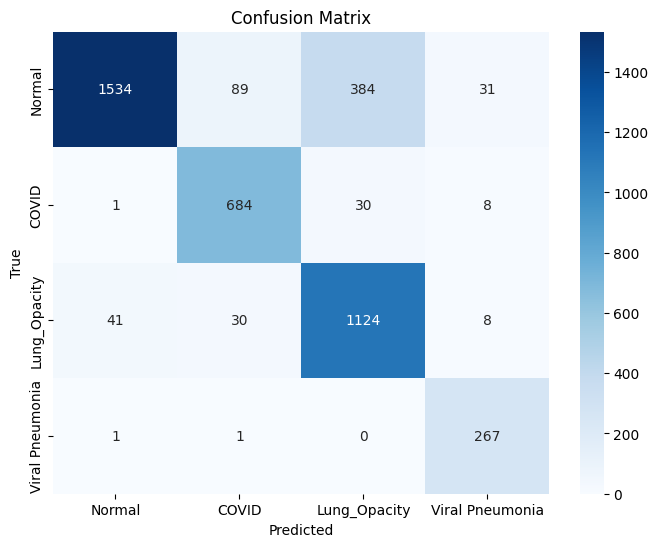

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_sample_weight_model, X_test, y_test)

In [ ]:
# save
cnn2_sample_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_sample_weight.h5")

## ConvNet (CNN2) - Weighted Loss Function (class weights)

In [ ]:
from sklearn.utils import compute_class_weight

In [ ]:
cnn2_class_weight_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_class_weight_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_35 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Tính toán class weights dựa trên tần suất xuất hiện của từng lớp trong tập huấn luyện
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_img), y=label_img)
class_weights = dict(enumerate(class_weights))

In [ ]:
cnn2_class_weight_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn2_class_weight_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/50
133/133 [==============================] - 8s 38ms/step - loss: 1.2517 - accuracy: 0.3361 - val_loss: 1.0396 - val_accuracy: 0.5471
Epoch 2/50
133/133 [==============================] - 5s 35ms/step - loss: 0.9199 - accuracy: 0.5596 - val_loss: 1.0752 - val_accuracy: 0.5863
Epoch 3/50
133/133 [==============================] - 5s 34ms/step - loss: 0.8231 - accuracy: 0.5989 - val_loss: 0.8192 - val_accuracy: 0.6745
Epoch 4/50
133/133 [==============================] - 5s 35ms/step - loss: 0.7598 - accuracy: 0.6264 - val_loss: 0.7264 - val_accuracy: 0.7009
Epoch 5/50
133/133 [==============================] - 5s 36ms/step - loss: 0.7158 - accuracy: 0.6555 - val_loss: 1.0791 - val_accuracy: 0.4318
Epoch 6/50
133/133 [==============================] - 5s 35ms/step - loss: 0.6683 - accuracy: 0.6756 - val_loss: 0.6837 - val_accuracy: 0.7416
Epoch 7/50
133/133 [==============================] - 5s 36ms/step - loss: 0.6335 - accuracy: 0.6974 - val_loss: 0.5988 - val_accuracy: 0.7692

133/133 [==============================] - 1s 3ms/step
Accuracy: 0.9052681313489251

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.93      0.91      0.92      2038
          COVID       0.87      0.95      0.91       723
   Lung_Opacity       0.91      0.85      0.88      1203
Viral Pneumonia       0.82      1.00      0.90       269

       accuracy                           0.91      4233
      macro avg       0.88      0.93      0.90      4233
   weighted avg       0.91      0.91      0.91      4233


Precision, Recall, F1-score:

Normal
Precision: 0.934409687184662
Recall: 0.9087340529931305
F1-score: 0.9213930348258706

COVID
Precision: 0.8661616161616161
Recall: 0.9488243430152143
F1-score: 0.9056105610561055

Lung_Opacity
Precision: 0.9071618037135278
Recall: 0.8528678304239401
F1-score: 0.8791773778920308

Viral Pneumonia
Precision: 0.8170731707317073
Recall: 0.9962825278810409
F1-score: 0.897822445561139



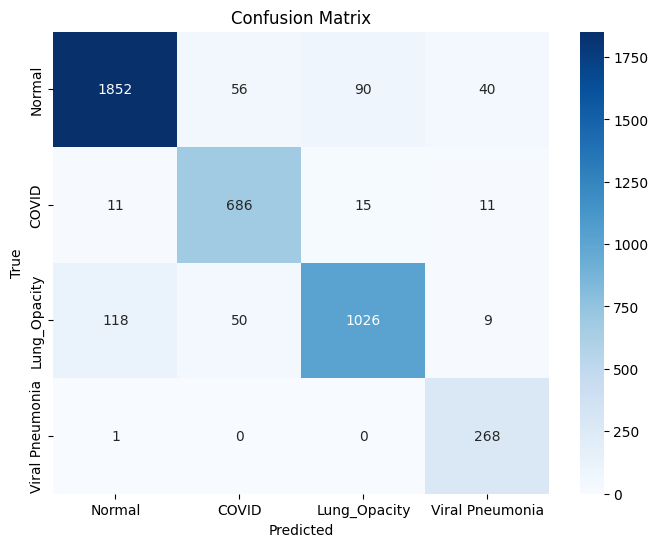

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_class_weight_model, X_test, y_test)

In [ ]:
# save
cnn2_class_weight_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_class_weight.h5")

## ConvNet (CNN2) - Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten

In [ ]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [ ]:
cnn2_aug_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_aug_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_43 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()

# Tiền xử lý cho X_train_aug
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_train_aug = X_train_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug, y_train, batch_size=128)

In [ ]:
# Compile mô hình
cnn2_aug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình với data augmentation
cnn2_aug_model.fit(augmented_X_train, epochs=50, validation_data=(X_test_aug, y_test))

Epoch 1/50
133/133 [==============================] - 27s 102ms/step - loss: 1.2011 - accuracy: 0.4790 - val_loss: 1.1925 - val_accuracy: 0.4815
Epoch 2/50
133/133 [==============================] - 11s 85ms/step - loss: 1.1908 - accuracy: 0.4816 - val_loss: 1.1870 - val_accuracy: 0.4815
Epoch 3/50
133/133 [==============================] - 11s 84ms/step - loss: 1.1883 - accuracy: 0.4816 - val_loss: 1.1883 - val_accuracy: 0.4815
Epoch 4/50
133/133 [==============================] - 10s 74ms/step - loss: 1.1876 - accuracy: 0.4816 - val_loss: 1.1902 - val_accuracy: 0.4815
Epoch 5/50
133/133 [==============================] - 11s 85ms/step - loss: 1.1879 - accuracy: 0.4816 - val_loss: 1.1873 - val_accuracy: 0.4815
Epoch 6/50
133/133 [==============================] - 12s 87ms/step - loss: 1.1877 - accuracy: 0.4816 - val_loss: 1.1867 - val_accuracy: 0.4815
Epoch 7/50
133/133 [==============================] - 11s 85ms/step - loss: 1.1875 - accuracy: 0.4816 - val_loss: 1.1874 - val_accuracy

133/133 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy: 0.48145523269548784

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.48      1.00      0.65      2038
          COVID       0.00      0.00      0.00       723
   Lung_Opacity       0.00      0.00      0.00      1203
Viral Pneumonia       0.00      0.00      0.00       269

       accuracy                           0.48      4233
      macro avg       0.12      0.25      0.16      4233
   weighted avg       0.23      0.48      0.31      4233


Precision, Recall, F1-score:

Normal
Precision: 0.48145523269548784
Recall: 1.0
F1-score: 0.649976080369957

COVID
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Lung_Opacity
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Viral Pneumonia
Precision: 0.0
Recall: 0.0
F1-score: 0.0



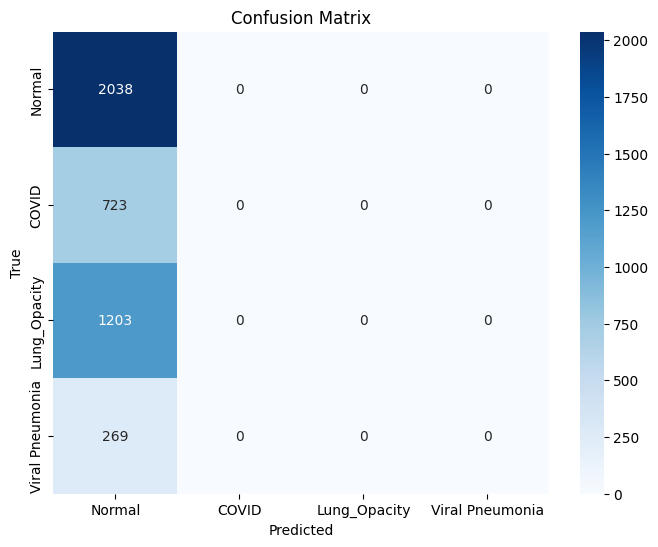

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_aug_model, X_test_aug, y_test)

In [ ]:
# save
cnn2_aug_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_augmentation.h5")

## ConvNet (CNN2) - Kết hợp Data Augmentation và Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Tạo đối tượng ImageDataGenerator với các thuộc tính augmentation mong muốn
datagen = ImageDataGenerator(
    rotation_range=30,  # Góc xoay trong khoảng -30 đến 30 độ
    width_shift_range=0.1,  # Dịch chuyển theo chiều ngang trong khoảng -0.1 đến 0.1
    height_shift_range=0.1,  # Dịch chuyển theo chiều dọc trong khoảng -0.1 đến 0.1
    zoom_range=0.1,  # Tăng giảm tỷ lệ thu phóng trong khoảng 0.9 đến 1.1
    horizontal_flip=True,  # Lật ảnh theo chiều ngang (ngang dọc)
    vertical_flip=False,  # Không lật ảnh theo chiều dọc
    fill_mode='nearest'  # Sử dụng fill mode nearest
)

In [ ]:
cnn2_aug_over_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn2_aug_over_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_49 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 31, 31, 32)        9248      
                                                                 
 conv2d_51 (Conv2D)          (None, 29, 29, 32)        9248      
                                                      

In [ ]:
# Sao chép X_train và X_test để giữ nguyên dữ liệu gốc
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
# Chuẩn bị dữ liệu augmentation
datagen.fit(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1))  # Thay đổi kích thước thành (samples, 64, 64, 1)

# Áp dụng augmentation cho X_train_aug để tạo X_aug_train
augmented_X_train = datagen.flow(X_train_aug.reshape(X_train_aug.shape[0], 64, 64, 1), y_train, batch_size=128)

# Chuyển đổi dữ liệu X_aug_train thành 2D
X_aug_train_2d = augmented_X_train[0][0].reshape(augmented_X_train[0][0].shape[0], -1)

# Áp dụng Oversampling trên dữ liệu tăng cường 2D
over_sampler = RandomOverSampler(sampling_strategy='auto')
X_aug_oversampling, y_aug_oversampling = over_sampler.fit_resample(X_aug_train_2d, augmented_X_train[0][1])

# Đưa dữ liệu X_aug_oversampling về 3D
X_aug_oversampling = X_aug_oversampling.reshape(X_aug_oversampling.shape[0], 64, 64, 1)

# Tiền xử lý cho X_train_aug
X_train_aug = X_aug_oversampling.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Tiền xử lý cho X_test_aug
X_test_aug = X_test_aug.reshape(X_test_aug.shape[0], 64, 64, 1)  # Reshape thành (samples, 64, 64, 1)
X_test_aug = X_test_aug.astype('float32') / 255.0  # Chuẩn hóa giá trị về khoảng [0, 1]

# Kết hợp dữ liệu tăng cường và dữ liệu oversampling
X_combined = np.concatenate((X_aug_oversampling, X_test_aug), axis=0)
y_combined = np.concatenate((y_aug_oversampling, y_test), axis=0)

In [ ]:
# Biên dịch mô hình
cnn2_aug_over_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã được tăng cường và oversampling
cnn2_aug_over_model.fit(X_combined, y_combined, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
139/139 [==============================] - 7s 22ms/step - loss: 1.2177 - accuracy: 0.4670 - val_loss: 1.2202 - val_accuracy: 0.4815
Epoch 2/50
139/139 [==============================] - 2s 14ms/step - loss: 1.2028 - accuracy: 0.4706 - val_loss: 1.2975 - val_accuracy: 0.4815
Epoch 3/50
139/139 [==============================] - 2s 14ms/step - loss: 1.2027 - accuracy: 0.4709 - val_loss: 1.2929 - val_accuracy: 0.4815
Epoch 4/50
139/139 [==============================] - 2s 14ms/step - loss: 1.2002 - accuracy: 0.4729 - val_loss: 1.2247 - val_accuracy: 0.4815
Epoch 5/50
139/139 [==============================] - 2s 16ms/step - loss: 1.1979 - accuracy: 0.4733 - val_loss: 1.1684 - val_accuracy: 0.4815
Epoch 6/50
139/139 [==============================] - 2s 17ms/step - loss: 1.1957 - accuracy: 0.4767 - val_loss: 1.1306 - val_accuracy: 0.4574
Epoch 7/50
139/139 [==============================] - 2s 16ms/step - loss: 1.1916 - accuracy: 0.4769 - val_loss: 1.2062 - val_accuracy: 0.4222

133/133 [==============================] - 0s 3ms/step
Accuracy: 0.6609969288920388

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.68      0.86      0.76      2038
          COVID       0.42      0.08      0.13       723
   Lung_Opacity       0.63      0.73      0.68      1203
Viral Pneumonia       0.88      0.42      0.57       269

       accuracy                           0.66      4233
      macro avg       0.65      0.52      0.53      4233
   weighted avg       0.63      0.66      0.62      4233


Precision, Recall, F1-score:

Normal
Precision: 0.6779791747011183
Recall: 0.8626104023552502
F1-score: 0.7592312675448066

COVID
Precision: 0.4230769230769231
Recall: 0.07607192254495158
F1-score: 0.12895662368112543

Lung_Opacity
Precision: 0.631236442516269
Recall: 0.7256857855361596
F1-score: 0.6751740139211136

Viral Pneumonia
Precision: 0.8818897637795275
Recall: 0.4163568773234201
F1-score: 0.5656565656565656



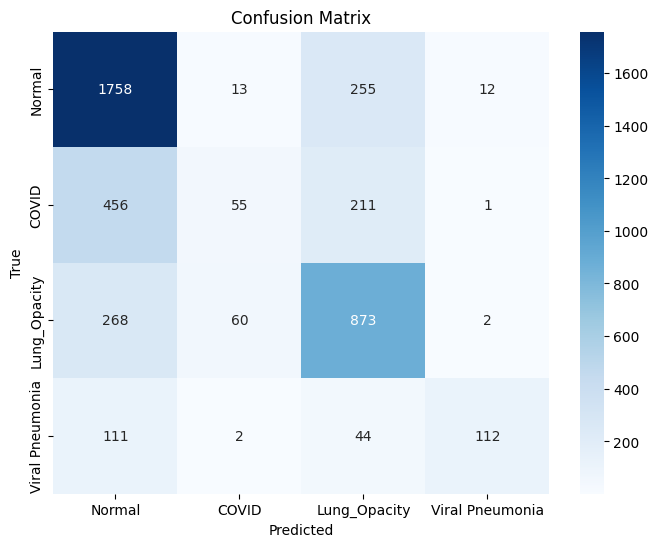

In [ ]:
# Sử dụng hàm evaluate_model để đánh giá mô hình đã huấn luyện
evaluate_model(cnn2_aug_over_model, X_test, y_test)

In [ ]:
# save
cnn2_aug_over_model.save("/content/Drive/MyDrive/[DS312.N21.GROUP09] MODEL/cnn2_aug_over.h5")